In [1]:
from PIL import Image, ImageDraw
from IPython.display import display
import numpy as np
import cv2, os
import matplotlib.pyplot as plt

def crop_circle(image, radius, center):
    """
    裁剪灰度图像中的圆形区域。

    参数:
    image_path: 图像的路径。
    radius: 圆的半径。
    center: 圆的中心点坐标（x, y）。如果为None，则使用图像中心。
    """

    width, height = image.size

    # 创建遮罩
    mask = Image.new('L', (width, height), 0)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((center[0]-radius, center[1]-radius, center[0]+radius, center[1]+radius), fill=255)

    # 应用遮罩
    result = Image.new('L', (width, height))
    result.paste(image, (0, 0), mask)

    return result

def crop_rectangle(img, crop_rectangle):
    # 裁剪图像
    cropped_image = img.crop(crop_rectangle)
    return cropped_image

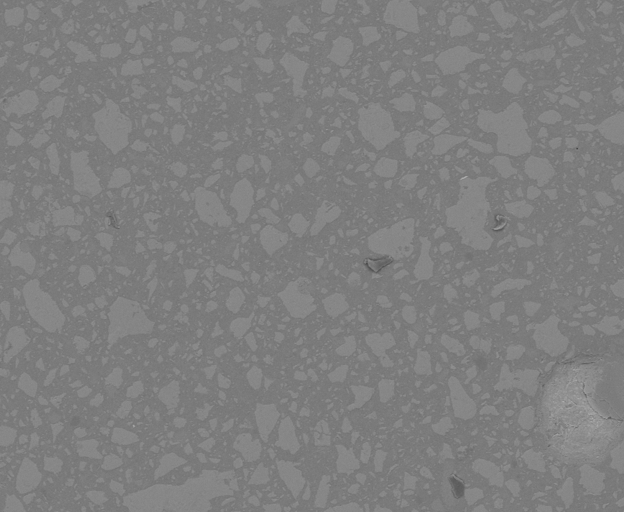

In [41]:


# HACK 记得把这些参数记录一下！

sample_index = 4
bse_sample_index = 2
zoom_times = 100
middle = zoom_times // 100
end_index = 1

file_name = f"{sample_index}-{middle}-{end_index}"

# BSE 图像裁剪以及对比度增强处理
src_path = f"G:/BSE/{sample_index}/S{bse_sample_index}/{zoom_times}/{file_name}.bmp"
#config
save_path = f"D:/workspace/ml-workspace/registration/datasets/sample{sample_index}/bse/s{bse_sample_index}/{zoom_times}"
if not os.path.isdir(save_path):
    # 如果文件夹不存在，创建它
    os.makedirs(save_path)

# 加载图像（替换为您的图像路径）
image_path = src_path  # 替换为您的图像路径
downsamp_save_path = f'{save_path}/{file_name}-downsamp.bmp'  # 单单裁剪的图像路径，只是把底下的那个比例尺条裁剪去，以及下采样
roi_save_path = f'{save_path}/{file_name}-downsamp-roi.bmp'
roi_enhanced_save_path = f'{save_path}/{file_name}-enhanced-roi.bmp'

# 中心点偏移量
center_offset_x = 40
center_offset_y = -90
crop_radius = 580

# 矩形裁剪配置
# rect # (left, upper, right, lower)
# 这个rect实际上也就是左上角后右下角点
rect_left = 66
rect_right = 1236
scale_bar_height = 64
# roi区域的大小
rect_roi_width = 624
rect_roi_height = 512

# 计算好的缩小倍数
subsample_100 = 1.39139

# 打开图像
image = Image.open(image_path).convert('L')  # 确保图像是灰度的
# 调用函数
# 替换为你的图像路径和所需的圆形参数
# 使用示例
# 如果未指定中心，使用图像中心
width, height = image.size
center = ((width // 2) + center_offset_x , (height // 2) + center_offset_y)
result_image = crop_circle(image, radius=crop_radius, center=center)

# 再对底部区域进行裁剪
crop_rect = (rect_left, 0, rect_left + rect_right, result_image.height - scale_bar_height)
result_image = crop_rectangle(result_image, crop_rect)

# 缩放倍数
sample_times = subsample_100
# 进行下采样
# 新尺寸
new_size = (round(result_image.width / sample_times) , round(result_image.height / sample_times))
# 使用双三次插值下采样图像
resized_image = result_image.resize(new_size, Image.BICUBIC)
# 保存图像为BMP格式
resized_image.save(downsamp_save_path, format='BMP')

# 裁剪时偏移量
roi_cropped_offset = (-3, -25)

width_ = resized_image.width
height_ = resized_image.height
center_new = (roi_cropped_offset[0] + resized_image.width // 2, 
              roi_cropped_offset[1] +  height_ // 2)

# 裁剪为我们的兴趣域大小
roi_rect = (center_new[0] - rect_roi_width//2, center_new[1] - rect_roi_height//2,
            center_new[0] + rect_roi_width//2, center_new[1] + rect_roi_height//2)
roi_result = crop_rectangle(resized_image, roi_rect)
roi_result.save(roi_save_path, format='BMP')

display(roi_result)


uint8 (512, 624)


(<Axes: >, <BarContainer object of 256 artists>, (0.0, 256.0))

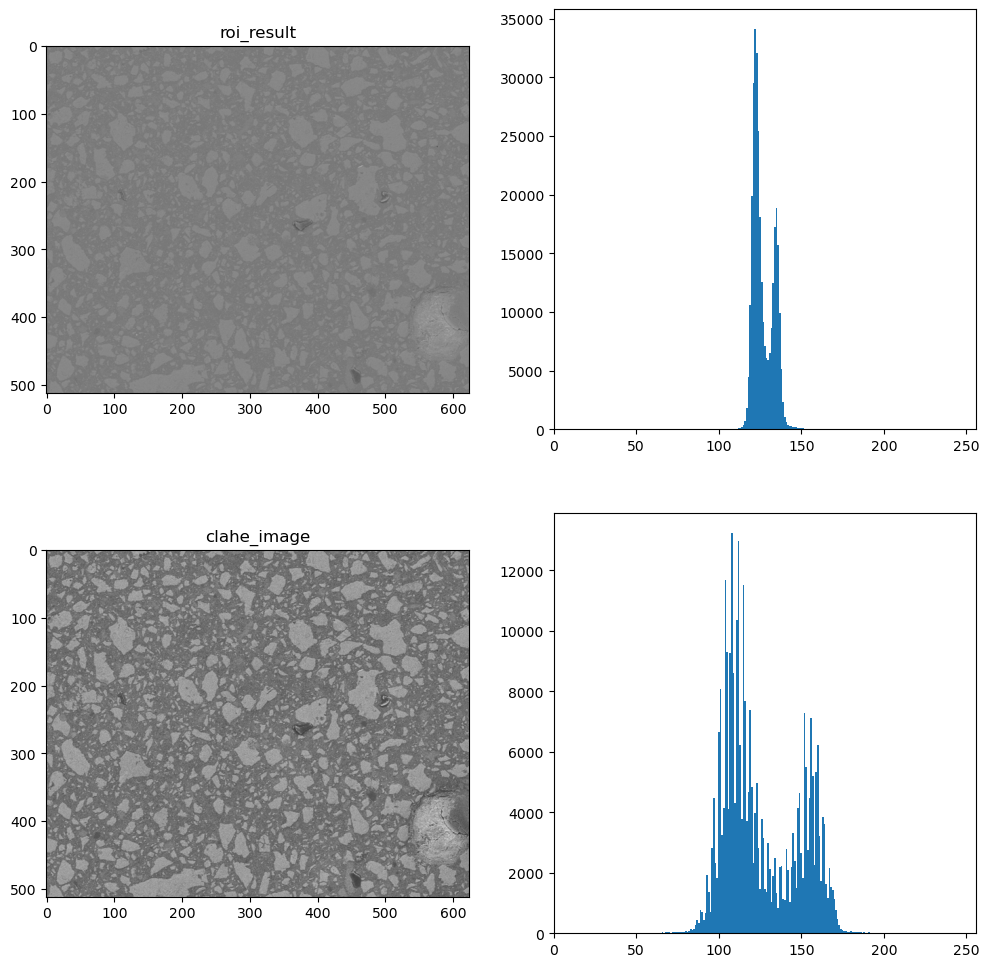

In [42]:
roi_result = np.array(roi_result)
# 创建 CLAHE 对象
# # 第一个参数是所有的像素强度减少为原来的1/3，多余的强度分散给其它像素
# clipLimit 参数控制了对直方图的剪切水平，影响对比度增强的强度。在设置时可以考虑以下因素：
# 图像的对比度和噪声水平：对于对比度较低且噪声水平不高的图像，可以尝试较高的 clipLimit 值，以增强对比度。相反，如果图像已有较高的对比度或者较多的噪声，较低的 clipLimit 值会更适合，以避免过度增强。
# 常用的取值范围：一般来说，clipLimit 的值可以从 1.0 到 4.0 之间进行调整。一个常用的起始点是 2.0 或 3.0，然后根据具体情况进行微调。
# 视觉效果和实验：最终，确定 clipLimit 的最佳值通常需要依据视觉效果进行实验。可以从一个中间值开始，然后根据图像的视觉改进来增加或减少该值。
# 图像类型和应用场景：不同类型的图像（如医学图像、卫星图像等）和不同的应用场景可能需要不同的 clipLimit 设置。医学图像可能需要更精细的对比度调整，而普通的景物照片可能对噪声放大更为敏感。


# 第二个tileGridSize参数指的是图像被分割成的小区域（或称为"瓦片"）的大小，8*8个像素自己进行自适应。
# 对于较小的图像（如小于 256x256 像素），更小的瓦片尺寸（例如 4x4）可能更合适，因为较小的图像中不需要太强的局部调整。
# 对于较大的图像（如大于 1024x1024 像素），可能需要更大的瓦片尺寸，例如 16x16 或 32x32，以避免过度的局部对比度调整和减少计算量。
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
print(roi_result.dtype, roi_result.shape)
# 应用 CLAHE
clahe_image = clahe.apply(roi_result)

roi_enhanced = Image.fromarray(clahe_image.astype('uint8'), 'L')  # 'RGB' for color images
roi_enhanced.save(roi_enhanced_save_path, format="BMP")

roi_hist = cv2.calcHist([roi_result], [0], None, [256], [0, 256])
clahe_hist = cv2.calcHist([clahe_image], [0], None, [256], [0, 256])


plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1), plt.imshow(roi_result, cmap='gray', vmin=0, vmax=255), plt.title('roi_result')
plt.subplot(2, 2, 3), plt.imshow(clahe_image, cmap='gray', vmin=0, vmax=255), plt.title('clahe_image')
plt.subplot(2, 2, 2), plt.bar(range(256), roi_hist.ravel(), width=1), plt.xlim([0, 256])
plt.subplot(2, 2, 4), plt.bar(range(256), clahe_hist.ravel(), width=1), plt.xlim([0, 256])

In [ ]:
# 增强对比度
# CT图像对比度增强处理
path = "../datasets/sample4/ct/s1"
ct_enhanced_path = f'{path}/enhanced'


start_idx = 10
end_idx = 50

count = end_idx - start_idx + 1
print("========================start=============================")
for i in range(count):
    src_path = f"{path}/slice_{start_idx+i}.bmp"
    save_enhanced_path = f"{ct_enhanced_path}/slice_enhanced_{start_idx+i}.bmp"
    # 打开图像
    ct_image = Image.open(src_path).convert('L')  # 确保图像是灰度的
    ct_arr = np.array(ct_image)
    # 经验设置 4, 16x16 此时MI有最大值
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(16, 16))
    # 应用 CLAHE
    ct_clahe_image = clahe.apply(ct_arr)
    ct_enhanced = Image.fromarray(ct_clahe_image.astype('uint8'), 'L')  # 'RGB' for color images
    ct_enhanced.save(save_enhanced_path, format="BMP")
print("========================Done=============================")


# roi_hist = cv2.calcHist([ct_arr], [0], None, [256], [0, 256])
# clahe_hist = cv2.calcHist([ct_clahe_image], [0], None, [256], [0, 256])


# plt.figure(figsize=(12, 12))
# plt.subplot(2, 2, 1), plt.imshow(ct_arr, cmap='gray', vmin=0, vmax=255), plt.title('roi_result')
# plt.subplot(2, 2, 3), plt.imshow(ct_clahe_image, cmap='gray', vmin=0, vmax=255), plt.title('clahe_image')
# plt.subplot(2, 2, 2), plt.bar(range(256), roi_hist.ravel(), width=1), plt.xlim([0, 256])
# plt.subplot(2, 2, 4), plt.bar(range(256), clahe_hist.ravel(), width=1), plt.xlim([0, 256])
